# Extração das planilhas

In [7]:
import os
from glob import glob

# Buscar todos os arquivos Excel (.xls) na pasta "Planilhas"
file_paths = glob(os.path.join(pasta, '*.xls'))

for fpath in file_paths:
    try:
        # Carregar o arquivo Excel
        xls = pd.ExcelFile(fpath)
        
        # Verificar se existe a planilha "Estoques_2000-2020"
        if "Estoques_2000-2020" in xls.sheet_names:
            df_sheet = xls.parse("Estoques_2000-2020")
            
            # Gerar nome para o CSV de saída
            base_name = os.path.splitext(os.path.basename(fpath))[0]
            csv_path = os.path.join(pasta, f"{base_name}_Estoques_2000-2020.csv")
            
            # Salvar a planilha em CSV
            df_sheet.to_csv(csv_path, index=False)
            print(f"Arquivo convertido: {csv_path}")
        else:
            print(f"Planilha 'Estoques_2000-2020' não encontrada em {fpath}")
    except Exception as e:
        print(f"Erro ao processar {fpath}: {e}")

Arquivo convertido: Planilhas\AC_Mudancas_Estoques_00_10_12_14_16_18_20_serie_revisada_Estoques_2000-2020.csv
Arquivo convertido: Planilhas\AL_Mudancas_Estoques_00_10_12_14_16_18_20_serie_revisada_Estoques_2000-2020.csv
Arquivo convertido: Planilhas\AM_Mudancas_Estoques_00_10_12_14_16_18_20_serie_revisada_Estoques_2000-2020.csv
Arquivo convertido: Planilhas\AP_Mudancas_Estoques_00_10_12_14_16_18_20_serie_revisada_Estoques_2000-2020.csv
Arquivo convertido: Planilhas\BA_Mudancas_Estoques_00_10_12_14_16_18_20_serie_revisada_Estoques_2000-2020.csv
Arquivo convertido: Planilhas\Brasil_Mudancas_Estoques_00_10_12_14_16_18_20_serie_revisada_Estoques_2000-2020.csv
Arquivo convertido: Planilhas\CE_Mudancas_Estoques_00_10_12_14_16_18_20_serie_revisada_Estoques_2000-2020.csv
Arquivo convertido: Planilhas\DF_Mudancas_Estoques_00_10_12_14_16_18_20_serie_revisada_Estoques_2000-2020.csv
Arquivo convertido: Planilhas\ES_Mudancas_Estoques_00_10_12_14_16_18_20_serie_revisada_Estoques_2000-2020.csv
Arquiv

# Extração das variáveis

In [8]:
import pandas as pd
import os
import re

# Caminho da pasta com os arquivos .xls convertidos para .csv
pasta = "CSV"

# Categorias relevantes para fuzzy multiobjetivo
categorias_fuzzy = [
    "Área Agrícola",
    "Pastagem com Manejo",
    "Vegetação Florestal",
    "Mosaico de Ocupações em Área Florestal",
    "Mosaico de Ocupações em Área Campestre",
    "Área Descoberta",
    "Área Artificial",
    "Área Úmida"
]

# Lista para guardar os dados de todos os estados
registros = []

# Percorre cada arquivo na pasta
for arquivo in os.listdir(pasta):
    if arquivo.endswith(".csv"):
        caminho_arquivo = os.path.join(pasta, arquivo)
        estado = arquivo[:2].upper()  # extrair a sigla do estado do nome do arquivo (ex: AC, BA)

        try:
            df = pd.read_csv(caminho_arquivo)
            df.rename(columns={df.columns[0]: "Indicador"}, inplace=True)

            # Identificar linha das categorias
            linha_categorias_index = df[df["Indicador"].astype(str).str.contains("Estoque", case=False, na=False)].index[0] - 1
            categorias = df.iloc[linha_categorias_index, 1:].values

            # Filtrar linhas válidas (Estoque com ano)
            linhas_estoque = df[df["Indicador"].str.contains(r"Estoque \(\d{4}\)", na=False, regex=True)]

            for _, row in linhas_estoque.iterrows():
                ano = re.findall(r"\d{4}", row["Indicador"])[0]
                valores = row[1:].values

                linha_dict = {"Estado": estado, "Ano": int(ano)}
                for cat, val in zip(categorias, valores):
                    if isinstance(cat, str) and cat.strip() in categorias_fuzzy:
                        linha_dict[cat.strip()] = val
                registros.append(linha_dict)

        except Exception as e:
            print(f"Erro ao processar {arquivo}: {e}")

# Criar DataFrame final
df_final = pd.DataFrame(registros)

# Ordenar colunas
colunas_ordenadas = ["Estado", "Ano"] + [cat for cat in categorias_fuzzy if cat in df_final.columns]
df_final = df_final[colunas_ordenadas]
df_final = df_final.sort_values(by=["Estado", "Ano"])

# Salvar como CSV limpo e pronto para fuzzy MO
df_final.to_csv("estoques_fuzzy_todos_estados.csv", index=False)
print("✅ CSV salvo como estoques_fuzzy_todos_estados.csv")


✅ CSV salvo como estoques_fuzzy_todos_estados.csv


# Normalizar INPC

In [22]:
import pandas as pd

# Passo 1: Ler o arquivo manualmente
with open("INPC.txt", "r", encoding="utf-8") as f:
    linhas = f.readlines()

# Supomos que a primeira linha seja o cabeçalho separado por vírgula
cabecalho = linhas[0].strip().split(",")
dados = []
for linha in linhas[1:]:
    # Usar split() (que separa por espaços e tabulações)
    partes = linha.strip().split()
    if len(partes) >= 2:
        dados.append(partes[:2])

# Criar o DataFrame
df = pd.DataFrame(dados, columns=cabecalho)

# Passo 2: Converter a coluna "Valor" – trocar vírgula por ponto e converter para float
df["Valor"] = df["Valor"].astype(str).str.replace(",", ".").astype(float)

# Passo 3: Converter a coluna "Data" para datetime
# Mapeamento dos meses de português para número
month_map_num = {
    'jan': '01', 'fev': '02', 'mar': '03', 'abr': '04', 'mai': '05',
    'jun': '06', 'jul': '07', 'ago': '08', 'set': '09', 'out': '10',
    'nov': '11', 'dez': '12'
}

def convert_date(date_str):
    """
    Converte uma data no formato 'abr/79' para um datetime, assumindo o dia 01.
    Se o ano for >= 50, assume 1900+ano; caso contrário, 2000+ano.
    """
    date_str = date_str.strip()
    partes = date_str.split("/")
    if len(partes) != 2:
        return pd.NaT
    mes, ano = partes[0].strip(), partes[1].strip()
    mes_num = month_map_num.get(mes.lower())
    if not mes_num:
        return pd.NaT
    try:
        ano_int = int(ano)
    except:
        return pd.NaT
    full_year = 1900 + ano_int if ano_int >= 50 else 2000 + ano_int
    data_formatada = f"01/{mes_num}/{full_year}"
    return pd.to_datetime(data_formatada, format="%d/%m/%Y", errors="coerce")

df["Data"] = df["Data"].apply(convert_date)

# Remover linhas onde a conversão falhou
df = df.dropna(subset=["Data"])

# Passo 4: Extrair o ano
df["Ano"] = df["Data"].dt.year

# Passo 5: Calcular a média do INPC por ano
df_anual = df.groupby("Ano")["Valor"].mean().reset_index()
df_anual.rename(columns={"Valor": "INPC_Medio"}, inplace=True)

# Exibir os anos disponíveis para diagnóstico
print("Anos disponíveis:", df_anual["Ano"].tolist())

# Passo 6: Filtrar os anos que interessam (por exemplo, os anos dos estoques)
anos_estoques = [2000, 2010, 2012, 2014, 2016, 2018, 2020]
df_alinhado = df_anual[df_anual["Ano"].isin(anos_estoques)]

# Se não houver nenhum ano de interesse, salva todos os anos (para diagnóstico)
if df_alinhado.empty:
    print("Nenhum dos anos especificados foi encontrado; salvando todos os anos disponíveis.")
    df_alinhado = df_anual

# Passo 7: Salvar o resultado em CSV
df_alinhado.to_csv("inpc_alinhado_com_estoques.csv", index=False)
print("✅ Arquivo gerado: inpc_alinhado_com_estoques.csv")
print(df_alinhado)


Anos disponíveis: [1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024]
✅ Arquivo gerado: inpc_alinhado_com_estoques.csv
     Ano  INPC_Medio
21  2000    0.430000
31  2010    0.524167
33  2012    0.502500
35  2014    0.505000
37  2016    0.533333
39  2018    0.282500
41  2020    0.444167


# Normalização e Calculo das funções Fuzzy

In [ ]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Carregar a base de dados dos estoques de uso da terra
# O arquivo deve conter as colunas "Estado", "Ano" e as variáveis dos estoques
df = pd.read_csv("estoques_fuzzy_todos_estados.csv")  # Substitua pelo nome do seu arquivo

# Definir os critérios relevantes para o modelo fuzzy multiobjetivo
criterios = [
    "Área Agrícola",
    "Pastagem com Manejo",
    "Vegetação Florestal",
    "Mosaico de Ocupações em Área Florestal",
    "Mosaico de Ocupações em Área Campestre",
    "Área Descoberta",
    "Área Artificial",
    "Área Úmida"
]

# Definir o objetivo para cada critério:
# "max" indica que queremos maximizar o valor (quanto maior, melhor)
# "min" indica que queremos minimizar o valor (quanto menor, melhor)
objetivos = {
    "Área Agrícola": "max",
    "Pastagem com Manejo": "min",
    "Vegetação Florestal": "max",
    "Mosaico de Ocupações em Área Florestal": "max",
    "Mosaico de Ocupações em Área Campestre": "max",
    "Área Descoberta": "min",
    "Área Artificial": "min",
    "Área Úmida": "max"
}

# Criar uma cópia do DataFrame para aplicar a normalização sem alterar o original
df_norm = df.copy()

# Instanciar o normalizador Min-Max para ajustar os valores entre 0 e 1
scaler = MinMaxScaler()

# Aplicar a normalização para todas as colunas dos critérios
# Isso converte os valores absolutos (em km²) para uma escala de 0 a 1
df_norm[criterios] = scaler.fit_transform(df[criterios])

# Calcular a fuzzy membership (grau de pertinência, µ) para cada critério:
# Se o objetivo é maximizar, usamos o valor normalizado.
# Se o objetivo é minimizar, usamos o complemento (1 - valor normalizado).
for crit in criterios:
    if objetivos[crit] == "max":
        # Para critérios a maximizar, o valor normalizado é o grau de pertinência
        df_norm[crit + "_mu"] = df_norm[crit]
    else:
        # Para critérios a minimizar, definimos µ como 1 - valor normalizado
        df_norm[crit + "_mu"] = 1 - df_norm[crit]
        
# Definir a não-pertinência (ν) e hesitação (π) de forma simples:
# Aqui, ν é o complemento de µ, e π é definido como 0 (sem incerteza adicional)
for crit in criterios:
    df_norm[crit + "_nu"] = 1 - df_norm[crit + "_mu"]
    df_norm[crit + "_pi"] = 0  # Poderíamos ajustar se tivéssemos uma medida de incerteza

# Agregar os valores fuzzy em um índice global.
# Neste exemplo, calculamos a média simples dos graus de pertinência (µ) para todos os critérios.
# Esse índice global serve como o "fuzzy score" da alternativa.
df_norm["Fuzzy_Score"] = df_norm[[crit + "_mu" for crit in criterios]].mean(axis=1)

# Ordenar os dados de forma decrescente, de modo que as alternativas com maior fuzzy score apareçam primeiro
df_norm = df_norm.sort_values(by="Fuzzy_Score", ascending=False)

# Selecionar as colunas que serão exibidas no resultado final:
# "Estado", "Ano", o fuzzy score global e os valores µ para cada critério
colunas_resultado = ["Estado", "Ano", "Fuzzy_Score"] + [crit + "_mu" for crit in criterios]
resultado = df_norm[colunas_resultado]

# Salvar o resultado final em um CSV para análise posterior
resultado.to_csv("fuzzy_model_resultado.csv", index=False)

# Imprimir uma mensagem de confirmação e exibir as primeiras linhas do resultado
print("✅ Resultado do modelo fuzzy salvo em fuzzy_model_resultado.csv")
print(resultado.head())


✅ Resultado do modelo fuzzy salvo em fuzzy_model_resultado.csv
   Estado   Ano  Fuzzy_Score  Área Agrícola_mu  Pastagem com Manejo_mu  \
35     BR  2000     0.614753          0.666241                0.218208   
41     BR  2020     0.613741          1.000000                0.000000   
39     BR  2016     0.609975          0.934488                0.011766   
40     BR  2018     0.609237          0.964993                0.006200   
38     BR  2014     0.605333          0.906709                0.007410   

    Vegetação Florestal_mu  Mosaico de Ocupações em Área Florestal_mu  \
35                1.000000                                   1.000000   
41                0.920615                                   0.972096   
39                0.925846                                   0.994539   
40                0.923918                                   0.981723   
38                0.931974                                   0.975747   

    Mosaico de Ocupações em Área Campestre_mu  Área D

# Análise dos perfis

In [2]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Carregar a base dos estoques (assegure-se de que o arquivo contenha as colunas:
# "Estado", "Ano", "Área Agrícola", "Pastagem com Manejo", "Vegetação Florestal",
# "Mosaico de Ocupações em Área Florestal", "Mosaico de Ocupações em Área Campestre",
# "Área Descoberta", "Área Artificial" e "Área Úmida")
df = pd.read_csv("estoques_fuzzy_todos_estados.csv")

# Lista dos critérios a serem usados
criterios = [
    "Área Agrícola",
    "Pastagem com Manejo",
    "Vegetação Florestal",
    "Mosaico de Ocupações em Área Florestal",
    "Mosaico de Ocupações em Área Campestre",
    "Área Descoberta",
    "Área Artificial",
    "Área Úmida"
]

# Definir o objetivo de cada critério:
# "max" significa que quanto maior o valor, melhor (ex.: Vegetação Florestal)
# "min" significa que quanto menor o valor, melhor (ex.: Pastagem com Manejo, Área Artificial)
objetivos = {
    "Área Agrícola": "max",
    "Pastagem com Manejo": "min",
    "Vegetação Florestal": "max",
    "Mosaico de Ocupações em Área Florestal": "max",
    "Mosaico de Ocupações em Área Campestre": "max",
    "Área Descoberta": "min",
    "Área Artificial": "min",
    "Área Úmida": "max"
}

# -----------------------------
# PASSO 1: Normalização
# -----------------------------
# Cria uma cópia dos dados para normalizar os critérios sem alterar o original
df_norm = df.copy()

# Normaliza os dados dos critérios para a escala 0 a 1 (Min-Max)
scaler = MinMaxScaler()
df_norm[criterios] = scaler.fit_transform(df[criterios])

# -----------------------------
# PASSO 2: Cálculo da Função Fuzzy (grau de pertinência, µ)
# -----------------------------
# Para cada critério, se o objetivo é "max", então µ = valor normalizado;
# se "min", então µ = 1 - valor normalizado.
for crit in criterios:
    if objetivos[crit] == "max":
        df_norm[crit + "_mu"] = df_norm[crit]
    else:
        df_norm[crit + "_mu"] = 1 - df_norm[crit]
        
# (Opcional) Definindo não-pertinência (ν) como complemento de µ e hesitação (π) como 0.
for crit in criterios:
    df_norm[crit + "_nu"] = 1 - df_norm[crit + "_mu"]
    df_norm[crit + "_pi"] = 0  # Poderia ser ajustado se houvesse informação de incerteza

# -----------------------------
# PASSO 3: Definir os 4 perfis com pesos diferentes
# -----------------------------
# Perfil Conservador: valoriza a sustentabilidade, preservação ambiental e diversidade de uso.
perfil_conservador = {
    "Área Agrícola": 0.10,
    "Pastagem com Manejo": 0.10,
    "Vegetação Florestal": 0.30,
    "Mosaico de Ocupações em Área Florestal": 0.15,
    "Mosaico de Ocupações em Área Campestre": 0.15,
    "Área Descoberta": 0.05,
    "Área Artificial": 0.05,
    "Área Úmida": 0.10
}

# Perfil Produtivista: prioriza a produção, principalmente a área agrícola.
perfil_produtivista = {
    "Área Agrícola": 0.40,
    "Pastagem com Manejo": 0.10,
    "Vegetação Florestal": 0.10,
    "Mosaico de Ocupações em Área Florestal": 0.10,
    "Mosaico de Ocupações em Área Campestre": 0.10,
    "Área Descoberta": 0.05,
    "Área Artificial": 0.05,
    "Área Úmida": 0.10
}

# Perfil Especulativo: foca em identificar concentração de terra (alta pastagem e alta área artificial)
perfil_especulativo = {
    "Área Agrícola": 0.15,
    "Pastagem com Manejo": 0.30,
    "Vegetação Florestal": 0.10,
    "Mosaico de Ocupações em Área Florestal": 0.10,
    "Mosaico de Ocupações em Área Campestre": 0.10,
    "Área Descoberta": 0.05,
    "Área Artificial": 0.15,
    "Área Úmida": 0.05
}

# Perfil Exportador: foca na produção para exportação (alta área agrícola e redução da vegetação nativa)
perfil_exportador = {
    "Área Agrícola": 0.40,
    "Pastagem com Manejo": 0.05,
    "Vegetação Florestal": 0.05,
    "Mosaico de Ocupações em Área Florestal": 0.10,
    "Mosaico de Ocupações em Área Campestre": 0.10,
    "Área Descoberta": 0.05,
    "Área Artificial": 0.05,
    "Área Úmida": 0.20
}

# Agrupar os perfis num dicionário
perfis = {
    "perfil_conservador": perfil_conservador,
    "perfil_produtivista": perfil_produtivista,
    "perfil_especulativo": perfil_especulativo,
    "perfil_exportador": perfil_exportador
}

# -----------------------------
# PASSO 4: Cálculo do Fuzzy Score Ponderado para cada perfil
# -----------------------------
# Para cada perfil, o Fuzzy Score é calculado como a média ponderada dos valores de µ para cada critério.
for perfil, pesos in perfis.items():
    # Para cada linha, calcula a soma dos produtos (peso * µ) e divide pela soma dos pesos (que é 1, mas fazemos para manter a consistência)
    df_norm[perfil + "_Fuzzy_Score"] = df_norm.apply(
        lambda row: sum(row[crit + "_mu"] * pesos[crit] for crit in criterios) / sum(pesos.values()),
        axis=1
    )

# -----------------------------
# PASSO 5: Selecionar e salvar os resultados finais
# -----------------------------
# Seleciona as colunas "Estado", "Ano" e os fuzzy scores de cada perfil
colunas_resultado = ["Estado", "Ano"] + [perfil + "_Fuzzy_Score" for perfil in perfis.keys()]
resultado = df_norm[colunas_resultado]

# Ordena o resultado, por exemplo, usando o fuzzy score do perfil conservador
resultado = resultado.sort_values(by="perfil_conservador_Fuzzy_Score", ascending=False)

# Salvar o resultado final em um CSV para análise
resultado.to_csv("fuzzy_model_resultado_perfis.csv", index=False)
print("✅ Resultado do modelo fuzzy com 4 perfis salvo em fuzzy_model_resultado_perfis.csv")
print(resultado.head())


✅ Resultado do modelo fuzzy com 4 perfis salvo em fuzzy_model_resultado_perfis.csv
   Estado   Ano  perfil_conservador_Fuzzy_Score  \
35     BR  2000                        0.781884   
41     BR  2020                        0.772413   
39     BR  2016                        0.772059   
40     BR  2018                        0.771142   
38     BR  2014                        0.767145   

    perfil_produtivista_Fuzzy_Score  perfil_especulativo_Fuzzy_Score  \
35                         0.685876                         0.522714   
41                         0.789685                         0.492561   
39                         0.767578                         0.487695   
40                         0.776887                         0.486909   
38                         0.754522                         0.481677   

    perfil_exportador_Fuzzy_Score  
35                       0.724966  
41                       0.842760  
39                       0.820653  
40                       0.830323

# Resultados

In [7]:
import pandas as pd

# Carregar o CSV com os fuzzy scores
df = pd.read_csv("fuzzy_model_resultado_perfis.csv")

# Excluir registros de "BR" ou "Brasil" para considerar somente os estados individuais
df = df[~df["Estado"].isin(["BR", "Brasil"])]

# Lista dos nomes dos perfis (colunas de fuzzy score)
profiles = [
    "perfil_conservador_Fuzzy_Score", 
    "perfil_produtivista_Fuzzy_Score", 
    "perfil_especulativo_Fuzzy_Score", 
    "perfil_exportador_Fuzzy_Score"
]

# Dicionário para armazenar os melhores resultados por estado para cada perfil
best_by_profile = {}

# Para cada perfil, vamos agrupar por Estado e pegar a linha com o maior fuzzy score
for profile in profiles:
    # Para cada estado, pega o índice da linha com o máximo valor no perfil
    # Isso retornará, para cada estado, a linha (que contém o Ano e o fuzzy score) em que o valor é máximo.
    best = df.loc[df.groupby("Estado")[profile].idxmax()].copy()
    # Renomeia as colunas "Ano" e o fuzzy score para identificá-los no resultado combinado
    best = best[["Estado", "Ano", profile]]
    new_year_col = "Ano_" + profile.split("_")[1].lower()  # exemplo: "Ano_conservador"
    new_score_col = profile  # mantém o nome do fuzzy score
    best.rename(columns={"Ano": new_year_col, profile: new_score_col}, inplace=True)
    
    best_by_profile[profile] = best

# Agora, vamos unir os resultados de todos os perfis usando somente "Estado" como chave.
# Começamos com o DataFrame de um dos perfis e fazemos merge com os demais.
df_combined = best_by_profile[profiles[0]]
for profile in profiles[1:]:
    df_combined = pd.merge(df_combined, best_by_profile[profile], on="Estado", how="outer")

# Ordena o DataFrame combinado por um dos os fuzzy scores, se desejar (por exemplo, perfil conservador)
df_combined.sort_values(by="perfil_conservador_Fuzzy_Score", ascending=False, inplace=True)

# Exibe o resultado combinado
print("Ranking combinado - Melhor ano e fuzzy score por estado para cada perfil:")
print(df_combined)

# Salva o resultado combinado em um CSV
df_combined.to_csv("ranking_combinado_por_perfil.csv", index=False)
print("✅ Ranking combinado salvo em ranking_combinado_por_perfil.csv")


Ranking combinado - Melhor ano e fuzzy score por estado para cada perfil:
   Estado  Ano_conservador  perfil_conservador_Fuzzy_Score  Ano_produtivista  \
2      AM             2010                        0.331360              2012   
13     PA             2000                        0.286731              2000   
12     MT             2000                        0.258977              2020   
4      BA             2016                        0.256479              2020   
10     MG             2020                        0.245505              2020   
21     RR             2020                        0.228129              2020   
17     PR             2000                        0.221211              2018   
25     SP             2020                        0.217292              2020   
22     RS             2016                        0.217054              2020   
9      MA             2000                        0.216419              2020   
16     PI             2020                    

# Análise 1 – Análise de Séries Temporais (Evolução dos Fuzzy Scores por Estado)

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# Carrega o CSV com os resultados fuzzy
df = pd.read_csv("fuzzy_model_resultado_perfis.csv")

# Excluir registros do "BR" ou "Brasil" para focar apenas nos estados individuais
df = df[~df["Estado"].isin(["BR", "Brasil"])]

# Lista dos perfis que serão analisados
profiles = [
    "perfil_conservador_Fuzzy_Score",
    "perfil_produtivista_Fuzzy_Score",
    "perfil_especulativo_Fuzzy_Score",
    "perfil_exportador_Fuzzy_Score"
]

# Para cada perfil, cria uma pasta e gera os gráficos para cada estado
for profile in profiles:
    # Define o nome da pasta removendo a parte "_Fuzzy_Score"
    folder_name = profile.replace("_Fuzzy_Score", "")
    
    # Cria a pasta se ela não existir
    if not os.path.exists(folder_name):
        os.makedirs(folder_name)
    
    # Obtém a lista de estados
    estados = sorted(df["Estado"].unique())
    
    # Para cada estado, filtra os dados, plota e salva o gráfico na pasta correspondente
    for estado in estados:
        df_estado = df[df["Estado"] == estado].sort_values(by="Ano")
        
        plt.figure(figsize=(8, 5))
        plt.plot(df_estado["Ano"], df_estado[profile], marker='o', linestyle='-', label=estado)
        plt.title(f"Evolução do Fuzzy Score ({profile}) - Estado {estado}")
        plt.xlabel("Ano")
        plt.ylabel("Fuzzy Score")
        plt.grid(True)
        plt.legend()
        
        # Salva o gráfico na pasta do perfil, com nome que indica o estado
        filename = os.path.join(folder_name, f"Evolucao_Fuzzy_{estado}.png")
        plt.savefig(filename)
        plt.close()

print("✅ Gráficos de evolução temporal gerados e salvos em pastas separadas para cada perfil.")


✅ Gráficos de evolução temporal gerados e salvos em pastas separadas para cada perfil.


# Análise 2: Agrupa estados com características semelhantes (usando clustering) para identificar padrões regionais.

In [8]:
import pandas as pd
import os
from itertools import combinations
from sklearn.cluster import KMeans
import plotly.express as px

# Carregar o CSV com os resultados fuzzy
df = pd.read_csv("fuzzy_model_resultado_perfis.csv")

# Excluir registros referentes a "BR" ou "Brasil"
df = df[~df["Estado"].isin(["BR", "Brasil"])]

# Lista dos perfis a serem considerados
profiles = [
    "perfil_conservador_Fuzzy_Score", 
    "perfil_produtivista_Fuzzy_Score", 
    "perfil_especulativo_Fuzzy_Score", 
    "perfil_exportador_Fuzzy_Score"
]

# Agregar os dados para cada estado (média dos fuzzy scores, caso haja vários anos)
df_agg = df.groupby("Estado")[profiles].mean().reset_index()

# Criar uma pasta para armazenar os resultados (CSV e HTML)
output_folder = "cluster_results"
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Para cada combinação de dois perfis, realizar clusterização e salvar os resultados
for (p1, p2) in combinations(profiles, 2):
    # Subconjunto dos dados para os dois perfis
    df_pair = df_agg[["Estado", p1, p2]].copy()
    
    # Aplicar KMeans para agrupar os estados (neste exemplo, 3 clusters)
    kmeans = KMeans(n_clusters=3, random_state=42)
    df_pair["Cluster"] = kmeans.fit_predict(df_pair[[p1, p2]])
    
    # Nome da combinação (exemplo: "perfil_conservador_vs_perfil_produtivista")
    pair_name = f"{p1.replace('_Fuzzy_Score','')}_vs_{p2.replace('_Fuzzy_Score','')}"
    
    # Salvar o resultado em CSV
    output_csv = os.path.join(output_folder, f"ranking_{pair_name}.csv")
    df_pair.to_csv(output_csv, index=False)
    
    # Criar gráfico interativo com Plotly
    fig = px.scatter(
        df_pair,
        x=p1,
        y=p2,
        color="Cluster",
        text="Estado",
        hover_data=["Estado", p1, p2],
        title=f"Clusterização dos Estados: {pair_name}"
    )
    
    # Ajustar a posição e o tamanho do texto dos rótulos
    fig.update_traces(textposition="top center", textfont_size=10)
    
    # Salvar o gráfico interativo em um arquivo HTML
    output_html = os.path.join(output_folder, f"cluster_{pair_name}.html")
    fig.write_html(output_html)
    
    print(f"Resultados para {pair_name} salvos: CSV em {output_csv} e HTML em {output_html}")


Resultados para perfil_conservador_vs_perfil_produtivista salvos: CSV em cluster_results\ranking_perfil_conservador_vs_perfil_produtivista.csv e HTML em cluster_results\cluster_perfil_conservador_vs_perfil_produtivista.html
Resultados para perfil_conservador_vs_perfil_especulativo salvos: CSV em cluster_results\ranking_perfil_conservador_vs_perfil_especulativo.csv e HTML em cluster_results\cluster_perfil_conservador_vs_perfil_especulativo.html
Resultados para perfil_conservador_vs_perfil_exportador salvos: CSV em cluster_results\ranking_perfil_conservador_vs_perfil_exportador.csv e HTML em cluster_results\cluster_perfil_conservador_vs_perfil_exportador.html
Resultados para perfil_produtivista_vs_perfil_especulativo salvos: CSV em cluster_results\ranking_perfil_produtivista_vs_perfil_especulativo.csv e HTML em cluster_results\cluster_perfil_produtivista_vs_perfil_especulativo.html
Resultados para perfil_produtivista_vs_perfil_exportador salvos: CSV em cluster_results\ranking_perfil_prod

# Análise 3: Testa a sensibilidade dos rankings em função dos pesos, ajudando a validar a robustez do modelo.

In [14]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# -----------------------------------------------
# 1. Carregar os dados originais
# -----------------------------------------------
# Este arquivo deve conter os valores originais de uso da terra e já deve ter as colunas dos critérios,
# por exemplo: "Área Agrícola", "Pastagem com Manejo", "Vegetação Florestal", etc.
df = pd.read_csv("estoques_fuzzy_todos_estados.csv")

# Exclui registros agregados (Brasil) para manter somente os estados individuais
df = df[~df["Estado"].isin(["BR", "Brasil"])]

# -----------------------------------------------
# 2. Definir os critérios e objetivos
# -----------------------------------------------
criterios = [
    "Área Agrícola",
    "Pastagem com Manejo",
    "Vegetação Florestal",
    "Mosaico de Ocupações em Área Florestal",
    "Mosaico de Ocupações em Área Campestre",
    "Área Descoberta",
    "Área Artificial",
    "Área Úmida"
]

# Para cada critério, definimos se queremos maximizar ("max") ou minimizar ("min")
objetivos = {
    "Área Agrícola": "max",
    "Pastagem com Manejo": "min",
    "Vegetação Florestal": "max",
    "Mosaico de Ocupações em Área Florestal": "max",
    "Mosaico de Ocupações em Área Campestre": "max",
    "Área Descoberta": "min",
    "Área Artificial": "min",
    "Área Úmida": "max"
}

# -----------------------------------------------
# 3. Criar as colunas de fuzzy membership (_mu)
# -----------------------------------------------
# Aplicar Min–Max normalization para cada critério e, conforme o objetivo, calcular µ = valor_normalizado (se "max")
# ou µ = 1 - valor_normalizado (se "min").
scaler = MinMaxScaler()
for crit in criterios:
    if crit in df.columns:
        norm_vals = scaler.fit_transform(df[[crit]])
        col_mu = crit + "_mu"
        if objetivos[crit] == "max":
            df[col_mu] = norm_vals.flatten()
        else:
            df[col_mu] = 1 - norm_vals.flatten()
    else:
        print(f"A coluna '{crit}' não foi encontrada no dataframe.")

# -----------------------------------------------
# 4. Definir o perfil conservador e função para calcular fuzzy score
# -----------------------------------------------
# Pesos base para o perfil conservador
pesos_base = {
    "Área Agrícola": 0.10,
    "Pastagem com Manejo": 0.10,
    "Vegetação Florestal": 0.30,  # Este peso será variado na análise de sensibilidade
    "Mosaico de Ocupações em Área Florestal": 0.15,
    "Mosaico de Ocupações em Área Campestre": 0.15,
    "Área Descoberta": 0.05,
    "Área Artificial": 0.05,
    "Área Úmida": 0.10
}

def calc_fuzzy_score(row, pesos):
    total = sum(pesos.values())
    score = 0
    for crit in criterios:
        score += row[crit + "_mu"] * pesos[crit]
    return score / total

# Calcular o fuzzy score base para cada registro (usando os pesos originais)
df["fuzzy_score_base"] = df.apply(lambda row: calc_fuzzy_score(row, pesos_base), axis=1)

# -----------------------------------------------
# 5. Análise de Sensibilidade: Variação do peso de "Vegetação Florestal"
# -----------------------------------------------
# Vamos variar o peso de "Vegetação Florestal" de 0.25 a 0.35 em 5 passos
weight_range = np.linspace(0.25, 0.35, 5)

# Para cada registro (Estado–Ano), calcular os fuzzy scores para cada peso e, em seguida, as métricas de sensibilidade.
def sensitivity_metrics(row):
    scores = []
    for w in weight_range:
        mod_pesos = pesos_base.copy()
        mod_pesos["Vegetação Florestal"] = w
        score = calc_fuzzy_score(row, mod_pesos)
        scores.append(score)
    score_range = max(scores) - min(scores)
    score_std = np.std(scores)
    return pd.Series({"sensitivity_range": score_range, 
                      "sensitivity_std": score_std, 
                      "avg_score_mod": np.mean(scores)})

sensitivity_df = df.apply(sensitivity_metrics, axis=1)

# Criar um DataFrame final com Estado, Ano, fuzzy_score_base e as métricas de sensibilidade
df_sensitivity = pd.concat([df[["Estado", "Ano", "fuzzy_score_base"]], sensitivity_df], axis=1)

# Exibir os primeiros registros
print("Sensibilidade por registro (Estado–Ano):")
print(df_sensitivity.head())

# Salvar o resultado em um CSV
df_sensitivity.to_csv("sensibilidade_por_state_year.csv", index=False)
print("✅ Sensibilidade por Estado–Ano salva em sensibilidade_por_state_year.csv")

# -----------------------------------------------
# 6. Agregar a análise de sensibilidade por Estado
# -----------------------------------------------
# Calcular a média das métricas de sensibilidade para cada estado
df_state_sensitivity = df_sensitivity.groupby("Estado").mean().reset_index()
print("Sensibilidade agregada por Estado:")
print(df_state_sensitivity)

# Salvar os resultados agregados
df_state_sensitivity.to_csv("sensibilidade_agregada_por_estado.csv", index=False)
print("✅ Sensibilidade agregada por Estado salva em sensibilidade_agregada_por_estado.csv")


Sensibilidade por registro (Estado–Ano):
  Estado   Ano  fuzzy_score_base  sensitivity_range  sensitivity_std  \
0     AC  2000          0.232806           0.012909         0.004564   
1     AC  2010          0.230842           0.013127         0.004641   
2     AC  2012          0.230811           0.013141         0.004646   
3     AC  2014          0.230918           0.013243         0.004682   
4     AC  2016          0.230658           0.013242         0.004682   

   avg_score_mod  
0       0.232967  
1       0.231006  
2       0.230975  
3       0.231084  
4       0.230823  
✅ Sensibilidade por Estado–Ano salva em sensibilidade_por_state_year.csv
Sensibilidade agregada por Estado:
   Estado          Ano  fuzzy_score_base  sensitivity_range  sensitivity_std  \
0      AC  2012.857143          0.231103           0.013196         0.004666   
1      AL  2012.857143          0.220660           0.022056         0.007798   
2      AM  2012.857143          0.596628           0.039472     

# Análise 5: Visualiza espacialmente os fuzzy scores, permitindo identificar geograficamente onde os estados se destacam.

In [22]:
import geopandas as gpd
import pandas as pd
import plotly.express as px
import os

# Caminho para o shapefile dos estados do Brasil.
# Certifique-se de que "BR_UF_2023.shp" e os arquivos auxiliares (.shx, .dbf, etc.) estejam no diretório correto.
shapefile_path = "BR_UF_2023\BR_UF_2023.shp"

try:
    gdf = gpd.read_file(shapefile_path)
except Exception as e:
    print("Erro ao carregar o shapefile:", e)
    print("Verifique se o arquivo 'BR_UF_2023.shp' e seus arquivos auxiliares estão no caminho especificado.")
    raise

# Exibir as colunas do shapefile para confirmação
print("Colunas no shapefile:", gdf.columns.tolist())

# Carregar os fuzzy scores agregados por estado (arquivo com fuzzy scores para cada Estado–Ano)
df_scores = pd.read_csv("fuzzy_model_resultado_perfis.csv")

# Excluir registros agregados (Brasil) e manter somente os estados individuais
df_scores = df_scores[~df_scores["Estado"].isin(["BR", "Brasil"])]

# Agregar os fuzzy scores por estado (usando a média, se houver vários registros por estado)
profiles = [
    "perfil_conservador_Fuzzy_Score", 
    "perfil_produtivista_Fuzzy_Score", 
    "perfil_especulativo_Fuzzy_Score", 
    "perfil_exportador_Fuzzy_Score"
]
df_agg = df_scores.groupby("Estado")[profiles].mean().reset_index()

# Unir os dados geoespaciais com os fuzzy scores usando a coluna "SIGLA_UF" do shapefile e "Estado" do CSV.
# Certifique-se de que os valores estejam compatíveis (ex: ambas siglas em maiúsculas).
gdf_merged = gdf.merge(df_agg, left_on="SIGLA_UF", right_on="Estado", how="left")

# Cria uma pasta para salvar os mapas, se ela não existir.
output_folder = "fuzzy_maps"
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Para cada perfil, gera um mapa interativo com Plotly Express e salva o gráfico em HTML.
for profile in profiles:
    fig = px.choropleth(
        gdf_merged,
        geojson=gdf_merged.geometry.__geo_interface__,  # Utiliza a geometria do GeoDataFrame
        locations=gdf_merged.index,  # Usa o índice como identificador de localização
        color=profile,             # Cor com base no fuzzy score do perfil
        hover_name="SIGLA_UF",     # Exibe a sigla do estado
        hover_data=["NM_UF", profile],
        title=f"Fuzzy Score Médio ({profile}) por Estado"
    )
    
    # Ajusta a visualização geográfica
    fig.update_geos(fitbounds="locations", visible=False)
    fig.update_layout(margin={"r":0, "t":30, "l":0, "b":0})
    
    # Define o nome do arquivo HTML para salvar o gráfico
    output_html = os.path.join(output_folder, f"{profile}.html")
    fig.write_html(output_html)
    print(f"Map para {profile} salvo em {output_html}")

print("✅ Todos os mapas foram gerados e salvos.")


Colunas no shapefile: ['CD_UF', 'NM_UF', 'SIGLA_UF', 'CD_REGIAO', 'NM_REGIAO', 'AREA_KM2', 'geometry']
Map para perfil_conservador_Fuzzy_Score salvo em fuzzy_maps\perfil_conservador_Fuzzy_Score.html
Map para perfil_produtivista_Fuzzy_Score salvo em fuzzy_maps\perfil_produtivista_Fuzzy_Score.html
Map para perfil_especulativo_Fuzzy_Score salvo em fuzzy_maps\perfil_especulativo_Fuzzy_Score.html
Map para perfil_exportador_Fuzzy_Score salvo em fuzzy_maps\perfil_exportador_Fuzzy_Score.html
✅ Todos os mapas foram gerados e salvos.


# Análise 6: Compara os fuzzy scores em diferentes períodos, revelando mudanças temporais e possíveis impactos de políticas ou tendências


Tabela pivot para perfil_conservador_Fuzzy_Score:
Periodo Estado  2000-2010  2012-2020
0           AC   0.211291   0.210942
1           AL   0.203993   0.204174
2           AM   0.331341   0.331203
3           AP   0.209188   0.209311
4           BA   0.252732   0.256001
5           CE   0.210622   0.211841
6           DF   0.199662   0.199687
7           ES   0.204258   0.204283
8           GO   0.196983   0.196088
9           MA   0.214579   0.211332
10          MG   0.244472   0.244906
11          MS   0.213718   0.215059
12          MT   0.256453   0.255229
13          PA   0.281707   0.275666
14          PB   0.207194   0.208388
15          PE   0.210956   0.213151
16          PI   0.214554   0.215727
17          PR   0.221115   0.220867
18          RJ   0.202360   0.202313
19          RN   0.201812   0.202446
20          RO   0.210410   0.207593
21          RR   0.227697   0.228042
22          RS   0.215539   0.216719
23          SC   0.210417   0.210170
24          SE   0.20420

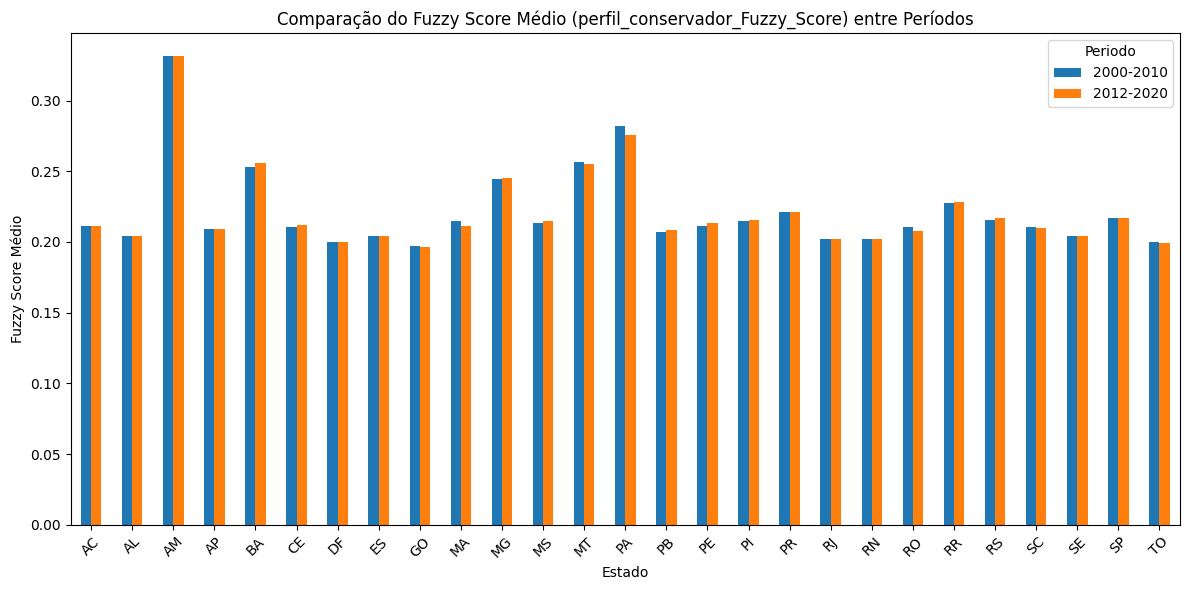


Tabela pivot para perfil_produtivista_Fuzzy_Score:
Periodo Estado  2000-2010  2012-2020
0           AC   0.203595   0.203374
1           AL   0.204573   0.204752
2           AM   0.258989   0.258911
3           AP   0.203435   0.203606
4           BA   0.239643   0.246601
5           CE   0.204567   0.205719
6           DF   0.200104   0.200197
7           ES   0.202877   0.203261
8           GO   0.217490   0.222780
9           MA   0.206816   0.206679
10          MG   0.241877   0.247475
11          MS   0.223843   0.230701
12          MT   0.269509   0.284654
13          PA   0.229968   0.228543
14          PB   0.205262   0.206099
15          PE   0.207983   0.209539
16          PI   0.209046   0.212800
17          PR   0.244946   0.246310
18          RJ   0.200486   0.200434
19          RN   0.200493   0.201034
20          RO   0.202478   0.201314
21          RR   0.218958   0.219385
22          RS   0.247464   0.252451
23          SC   0.209519   0.209695
24          SE   0.2030

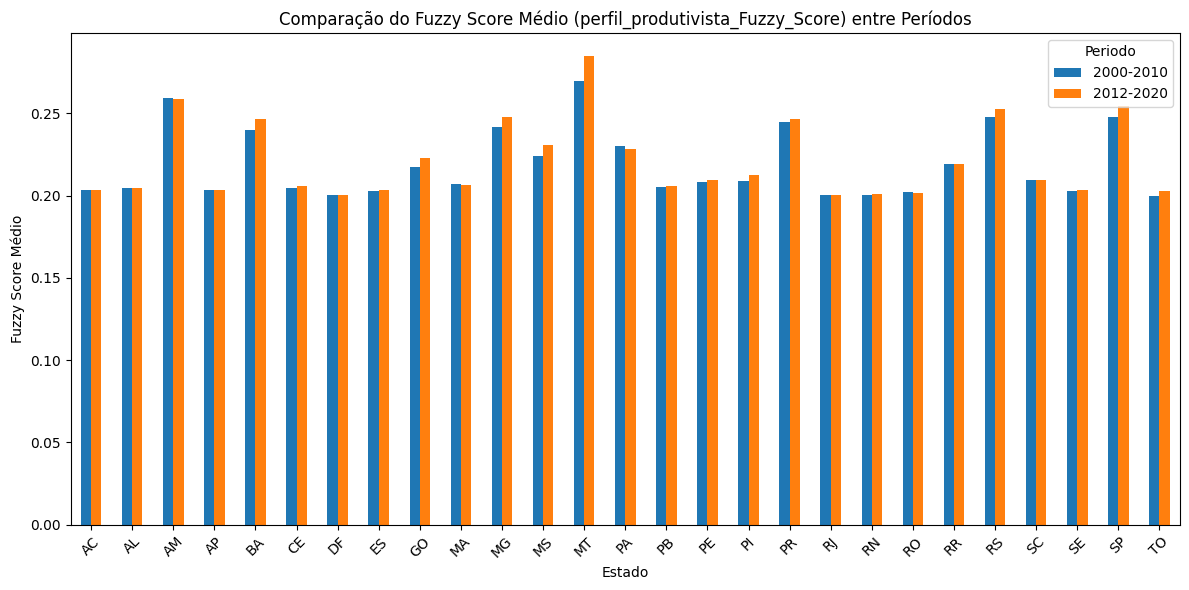


Tabela pivot para perfil_especulativo_Fuzzy_Score:
Periodo Estado  2000-2010  2012-2020
0           AC   0.501889   0.501043
1           AL   0.501987   0.502059
2           AM   0.545776   0.545217
3           AP   0.502973   0.503107
4           BA   0.519283   0.521499
5           CE   0.500865   0.501553
6           DF   0.498115   0.498133
7           ES   0.499323   0.499476
8           GO   0.467918   0.466695
9           MA   0.489033   0.483637
10          MG   0.498446   0.498883
11          MS   0.473490   0.477081
12          MT   0.495443   0.494240
13          PA   0.502092   0.489502
14          PB   0.503582   0.504310
15          PE   0.504271   0.505528
16          PI   0.506041   0.507123
17          PR   0.511276   0.511309
18          RJ   0.493256   0.493080
19          RN   0.496865   0.497029
20          RO   0.491732   0.486411
21          RR   0.511576   0.511784
22          RS   0.510908   0.512275
23          SC   0.503469   0.503037
24          SE   0.5019

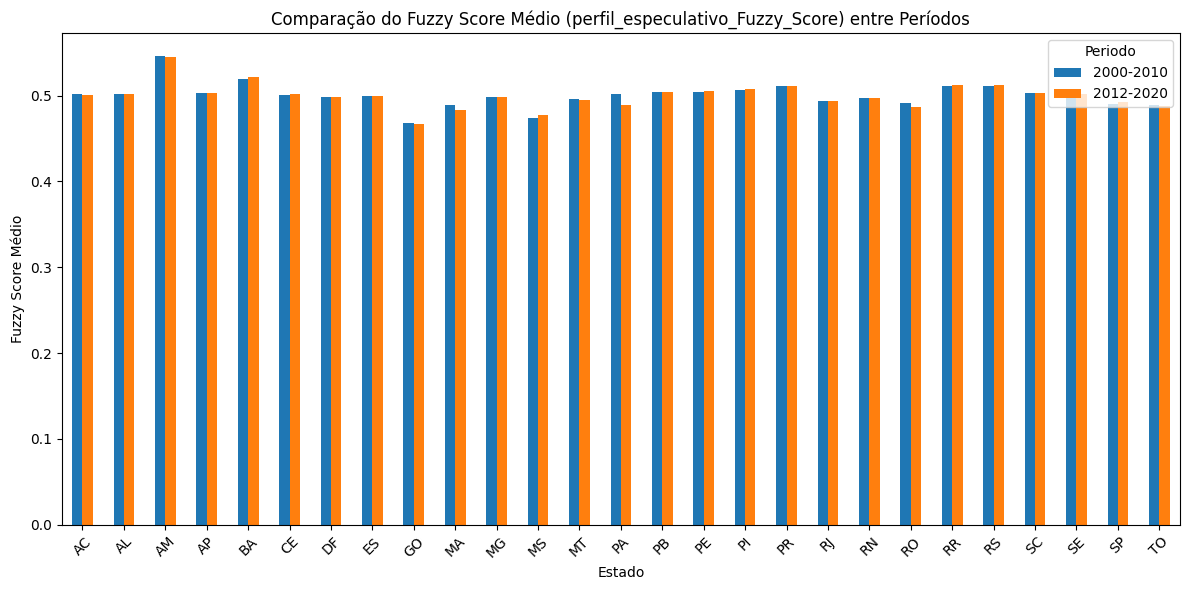


Tabela pivot para perfil_exportador_Fuzzy_Score:
Periodo Estado  2000-2010  2012-2020
0           AC   0.152177   0.152153
1           AL   0.154672   0.154855
2           AM   0.213648   0.213453
3           AP   0.152516   0.152689
4           BA   0.190606   0.197925
5           CE   0.154324   0.155496
6           DF   0.150106   0.150200
7           ES   0.153261   0.153648
8           GO   0.173584   0.179379
9           MA   0.167954   0.168647
10          MG   0.196077   0.201912
11          MS   0.198393   0.204934
12          MT   0.247335   0.264057
13          PA   0.181058   0.182514
14          PB   0.155250   0.156091
15          PE   0.158104   0.159673
16          PI   0.158455   0.162241
17          PR   0.195499   0.196848
18          RJ   0.150647   0.150606
19          RN   0.150555   0.151103
20          RO   0.153413   0.153422
21          RR   0.180811   0.181315
22          RS   0.197271   0.202262
23          SC   0.159308   0.159484
24          SE   0.153143

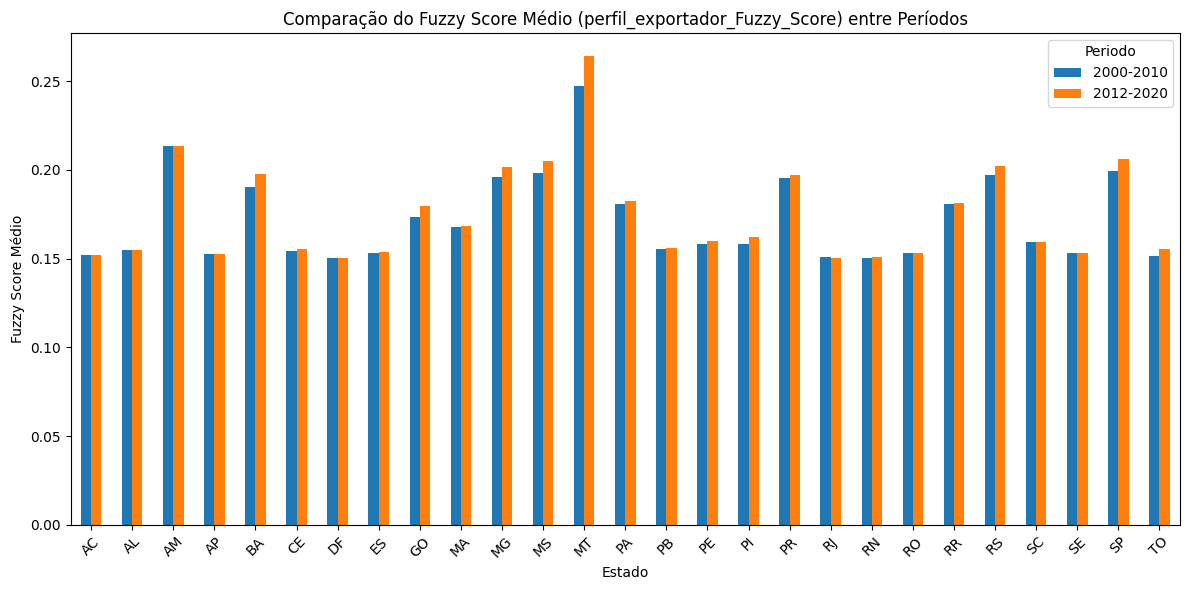

In [23]:
import pandas as pd
import matplotlib.pyplot as plt

# Carregar o arquivo com os fuzzy scores (por Estado e Ano)
df = pd.read_csv("fuzzy_model_resultado_perfis.csv")

# Filtrar para excluir registros agregados (Brasil)
df = df[~df["Estado"].isin(["BR", "Brasil"])]

# Função para definir o período com base no ano
def define_period(ano):
    if ano <= 2010:
        return "2000-2010"
    else:
        return "2012-2020"

# Criar a coluna "Periodo" a partir do ano
df["Periodo"] = df["Ano"].apply(define_period)

# Lista dos perfis fuzzy a serem analisados
profiles = [
    "perfil_conservador_Fuzzy_Score",
    "perfil_produtivista_Fuzzy_Score",
    "perfil_especulativo_Fuzzy_Score",
    "perfil_exportador_Fuzzy_Score"
]

# Para cada perfil, agrupar por Estado e Periodo, calcular a média e criar uma tabela pivot
for profile in profiles:
    # Agrupar por Estado e Periodo e calcular a média dos fuzzy scores
    df_grouped = df.groupby(["Estado", "Periodo"])[profile].mean().reset_index()
    
    # Criar uma tabela pivot: linhas = Estado, colunas = Período, valores = fuzzy score médio
    pivot = df_grouped.pivot(index="Estado", columns="Periodo", values=profile).reset_index()
    
    # Exibir a tabela pivot
    print(f"\nTabela pivot para {profile}:")
    print(pivot)
    
    # Salvar a tabela pivot em CSV
    pivot.to_csv(f"comparacao_periodos_{profile}.csv", index=False)
    print(f"Arquivo salvo: comparacao_periodos_{profile}.csv")
    
    # Gerar um gráfico de barras lado a lado para cada estado comparando os dois períodos
    ax = pivot.plot(x="Estado", kind="bar", figsize=(12, 6), title=f"Comparação do Fuzzy Score Médio ({profile}) entre Períodos")
    ax.set_xlabel("Estado")
    ax.set_ylabel("Fuzzy Score Médio")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


# NSGA III

In [18]:
import numpy as np
import pandas as pd
from pymoo.core.problem import ElementwiseProblem
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize

# Definir o problema multiobjetivo com 8 variáveis e 8 objetivos
class UsoDaTerraProblem(ElementwiseProblem):
    def __init__(self):
        # 8 variáveis de decisão, cada uma no intervalo [0,1]
        # 8 objetivos: para os que queremos maximizar, usamos -x (convertendo para minimização)
        super().__init__(n_var=8, n_obj=8, n_constr=0, xl=0.0, xu=1.0)
    
    def _evaluate(self, x, out, *args, **kwargs):
        # f0: Área Agrícola (maximizar) -> minimizamos -x0
        # f1: Pastagem com Manejo (minimizar) -> minimizamos x1
        # f2: Vegetação Florestal (maximizar) -> minimizamos -x2
        # f3: Mosaico de Ocupações em Área Florestal (maximizar) -> minimizamos -x3
        # f4: Mosaico de Ocupações em Área Campestre (maximizar) -> minimizamos -x4
        # f5: Área Descoberta (minimizar) -> minimizamos x5
        # f6: Área Artificial (minimizar) -> minimizamos x6
        # f7: Área Úmida (maximizar) -> minimizamos -x7
        f = np.array([
            -x[0],
             x[1],
            -x[2],
            -x[3],
            -x[4],
             x[5],
             x[6],
            -x[7]
        ])
        out["F"] = f

# Instanciar o problema
problem = UsoDaTerraProblem()

# Configurar o algoritmo NSGA-II com um tamanho de população de 1000
# e executar por 20.000 gerações (esses valores podem ser ajustados)
algorithm = NSGA2(pop_size=1000)
res = minimize(problem,
               algorithm,
               termination=('n_gen', 20000),
               seed=1,
               verbose=True)

# Converter os resultados da fronteira de Pareto em DataFrames:
# Pareto front: valores dos 8 objetivos
pareto_df = pd.DataFrame(res.F, columns=[f"f{i}" for i in range(8)])
# Soluções: os 8 valores das variáveis de decisão correspondentes
solutions_df = pd.DataFrame(res.X, columns=[f"x{i}" for i in range(8)])

# Concatenar os dois DataFrames para ter, em cada linha, os objetivos e as variáveis correspondentes
results_df = pd.concat([pareto_df, solutions_df], axis=1)

# Calcular o ponto ideal: para cada objetivo (todos são de minimização), o ideal é o menor valor observado
ideal_point = results_df[[f"f{i}" for i in range(8)]].min()

# Calcular a distância euclidiana de cada solução ao ponto ideal
results_df["distance_to_ideal"] = np.linalg.norm(results_df[[f"f{i}" for i in range(8)]].values - ideal_point.values, axis=1)

# Encontrar a solução com a menor distância (a solução "ideal")
ideal_solution = results_df.loc[results_df["distance_to_ideal"].idxmin()]

print("Solução ideal (mais próxima do ponto ideal):")
print(ideal_solution)

# Salvar os resultados em um CSV
results_df.to_csv("nsga2_pareto_results.csv", index=False)
print("✅ Os resultados da fronteira de Pareto foram salvos em 'nsga2_pareto_results.csv'")


n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |     1000 |    468 |             - |             -
     2 |     2000 |    759 |  0.0111448388 |         nadir
     3 |     3000 |   1000 |  0.1413889791 |             f
     4 |     4000 |   1000 |  0.1442476048 |             f
     5 |     5000 |   1000 |  0.1235634566 |             f
     6 |     6000 |   1000 |  0.1209250664 |             f
     7 |     7000 |   1000 |  0.1208995345 |             f
     8 |     8000 |   1000 |  0.1176976333 |             f
     9 |     9000 |   1000 |  0.1203640537 |             f
    10 |    10000 |   1000 |  0.1169512541 |             f
    11 |    11000 |   1000 |  0.1155661245 |             f
    12 |    12000 |   1000 |  0.1136605648 |             f
    13 |    13000 |   1000 |  0.1170951219 |             f
    14 |    14000 |   1000 |  0.1134876566 |             f
    15 |    15000 |   1000 |  0.0051521379 |         nadir
    16 |    16000 |   1000 |  0.0029826632 |         nad

In [20]:
import pandas as pd
import plotly.express as px
import dash
from dash import dcc, html, Input, Output, State

# Pré-processamento dos dados
df_pareto = pd.read_csv("nsga2_pareto_results.csv")

df_pareto.rename(columns={
    "f0": "Área Agrícola (max)",
    "f1": "Pastagem (min)",
    "f2": "Vegetação Florestal (max)",
    "f3": "Mosaico Florestal (max)",
    "f4": "Mosaico Campestre (max)",
    "f5": "Área Descoberta (min)",
    "f6": "Área Artificial (min)",
    "f7": "Área Úmida (max)"
}, inplace=True)

max_columns = ["Área Agrícola (max)", "Vegetação Florestal (max)", 
              "Mosaico Florestal (max)", "Mosaico Campestre (max)", 
              "Área Úmida (max)"]
for col in max_columns:
    df_pareto[col] = -df_pareto[col]

# Cria rótulos para cada solução
df_pareto['Solução'] = ["Sol " + str(i) for i in range(len(df_pareto))]

# Inicializa o Dash
app = dash.Dash(__name__)

app.layout = html.Div([
    html.Div([
        html.Label("Selecione as soluções para visualizar:"),
        dcc.Dropdown(
            id='solutions-dropdown',
            options=[{'label': sol, 'value': idx} for idx, sol in enumerate(df_pareto['Solução'])],
            multi=True,
            placeholder="Selecione as soluções..."
        ),
        html.Button('Mostrar Todas', id='show-all-button', n_clicks=0)
    ], style={'width': '50%', 'margin': '20px'}),
    
    dcc.Graph(id='parallel-coords')
])

@app.callback(
    Output('parallel-coords', 'figure'),
    Output('solutions-dropdown', 'value'),
    Input('solutions-dropdown', 'value'),
    Input('show-all-button', 'n_clicks'),
    prevent_initial_call=True
)
def update_graph(selected_solutions, reset_clicks):
    ctx = dash.callback_context
    
    if ctx.triggered_id == 'show-all-button':
        # Mostra todas as soluções ao clicar no botão
        return create_figure(df_pareto), None
    
    if selected_solutions:
        # Filtra o dataframe com base na seleção
        filtered_df = df_pareto[df_pareto.index.isin(selected_solutions)]
        return create_figure(filtered_df), selected_solutions
    
    return create_figure(df_pareto), no_update

def create_figure(dataframe):
    return px.parallel_coordinates(
        dataframe,
        dimensions=["Área Agrícola (max)", "Pastagem (min)", 
                    "Vegetação Florestal (max)", "Mosaico Florestal (max)",
                    "Mosaico Campestre (max)", "Área Descoberta (min)",
                    "Área Artificial (min)", "Área Úmida (max)"],
        color="Área Agrícola (max)",
        color_continuous_scale=px.colors.diverging.Tealrose,
        title="Fronteira de Pareto - Soluções Selecionadas"
    )

if __name__ == '__main__':
    app.run_server(debug=True)